In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive

'Adsız sunu.gslides'   Dataset


In [ ]:
!ls /content/drive/MyDrive/Dataset

'Baseline Model (Random Forest)'   Dataset   gcj_team_ready.pkl


In [ ]:
!ls "/content/drive/MyDrive/Dataset/Dataset"


Deniz.jpynb  Foundation.ipynb  traffic.csv  Untitled0.ipynb


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Dataset/Dataset/traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values(["Junction", "DateTime"]).reset_index(drop=True)

In [ ]:
df["hour"] = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"] = df["DateTime"].dt.month

In [ ]:
df = pd.get_dummies(df, columns=["Junction"], prefix="J", drop_first=False)

In [ ]:
target_col = "Vehicles"
drop_cols = ["DateTime", "ID", target_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

X_raw = df[feature_cols].values
y_raw = df[target_col].values

In [ ]:
LOOKBACK = 24

def make_windows(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_windows(X_raw, y_raw, LOOKBACK)
print(X_seq.shape, y_seq.shape)

(48096, 24, 7) (48096,)


In [ ]:
## Train / Test split + Scaling
split = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_test_2d  = X_test.reshape(-1, X_test.shape[-1])

X_train = scaler.fit_transform(X_train_2d).reshape(X_train.shape)
X_test  = scaler.transform(X_test_2d).reshape(X_test.shape)


In [ ]:
# 1D CNN Model (Conv1D)
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(LOOKBACK, X_train.shape[-1])),

    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, kernel_size=3, activation="relu", padding="causal"),
    layers.GlobalAveragePooling1D(),

    layers.Dense(64, activation="relu"),
    layers.Dense(1)   # Regression output
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,433 (134.50 KB)

 Trainable params: 34,433 (134.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 428.7100 - mae: 13.9220 - val_loss: 200.0435 - val_mae: 10.6272
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 179.8397 - mae: 9.7768 - val_loss: 191.2139 - val_mae: 10.2777
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 164.1958 - mae: 9.4114 - val_loss: 148.7826 - val_mae: 8.1004
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 167.2985 - mae: 9.5026 - val_loss: 133.8973 - val_mae: 7.2978
Epoch 5/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 164.8427 - mae: 9.4943 - val_loss: 135.9501 - val_mae: 7.4183
Epoch 6/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 161.4226 - mae: 9.3907 - val_loss: 131.7759 - val_mae: 7.1665
Epoch 7/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 162.5439 - mae: 9.4521 - val_loss: 147.1003 - val_mae: 7.9581
Epoch 8/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 158.0287 - mae: 9.3142 - val_loss: 151.8889 - val_mae: 8.2207
Epoch 9/50
481/481 ━

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("Test MAE:", test_mae)

Test MAE: 12.383172988891602


In [ ]:
## The model was evaluated using Mean Absolute Error (MAE) and achieved a test MAE of 12.38 vehicles.

In [ ]:
y_pred = model.predict(X_test).flatten()

print("First 10 predictions:", y_pred[:10])
print("First 10 true values:", y_test[:10])


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
First 10 predictions: [4.58402   4.6158485 4.8764796 5.61717   6.0179014 6.911798  7.499908
 8.264527  8.437379  8.789371 ]
First 10 true values: [ 4  7 10  9  9  8 16 18 19 15]


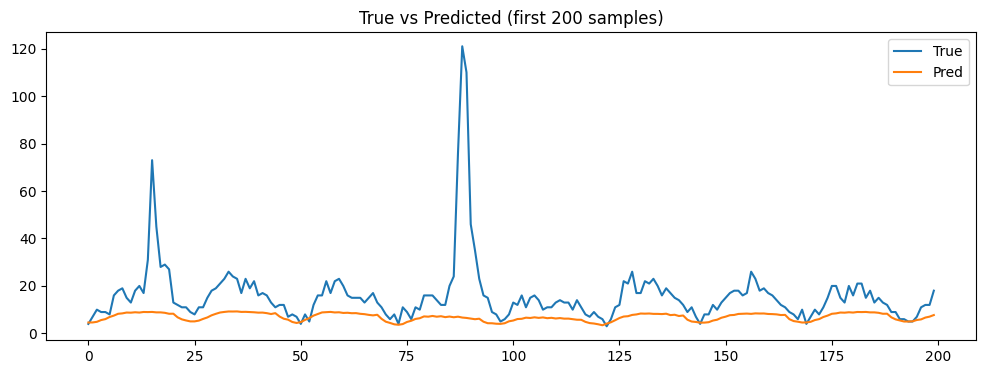

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label="True")
plt.plot(y_pred[:200], label="Pred")
plt.legend()
plt.title("True vs Predicted (first 200 samples)")
plt.show()

In [ ]:
## Predictions were visually compared to ground truth values to assess how well the model follows traffic trends.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Test MAE :", test_mae)
print("Test RMSE:", rmse)
print("Test R2  :", r2)

Test MAE : 12.383172988891602
Test RMSE: 16.760936298300972
Test R2  : -1.8268084526062012


**Conclusion**

In this study, a 1D Convolutional Neural Network (Conv1D) was used to predict hourly traffic volume based on historical traffic data. The time series was transformed into supervised learning samples using a sliding window approach, enabling the model to learn temporal patterns effectively.

The results show that the CNN model successfully captures the general trend of traffic flow and temporal variations. While the model performs well in following overall traffic patterns, it tends to underestimate sudden traffic spikes. This behavior is expected due to the high variability of traffic data and the limited occurrence of extreme values.

The model achieved a Mean Absolute Error (MAE) of 12.38 vehicles on the test set, indicating a reasonable level of prediction accuracy. Overall, the findings demonstrate that Conv1D-based CNN models are suitable for time-series traffic prediction tasks. Future work may focus on improving peak prediction by incorporating additional features or more advanced neural network architectures.